In [7]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [8]:
ROOT_DIR = os.getcwd()
dataset = os.path.join(ROOT_DIR, "dataset")

In [9]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [10]:
print("[INFO] loading images...")
#imagePaths = 
data = []
normal = os.path.join(dataset, 'normal')

c=0
for imgName in os.listdir(normal):
    if imgName[0] != '.' and c != 70:
        imagePath = os.path.join(normal, imgName)
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append(img)
        c+=1

print('Number of normal images :', len(data))

covid = os.path.join(dataset, 'covid')

for imgName in os.listdir(covid):
    if imgName[0] != '.':
        imagePath = os.path.join(covid, imgName)
        img = cv2.imread(imagePath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        data.append(img)
    
print('Number of covid images :', len(os.listdir(covid)))
print('Number of images :', len(data))

labels = ['normal' for name in os.listdir(os.path.join(dataset, 'normal'))] + ['covid' for name in os.listdir(os.path.join(dataset, 'covid'))]
print("labels...")
print(len(labels))

[INFO] loading images...
Number of normal images : 70
Number of covid images : 70
Number of images : 140
labels...
140


In [11]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [12]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [13]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [14]:
trainAug = ImageDataGenerator(
            rotation_range=15,
            fill_mode="nearest")

In [15]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 15s 0us/step


In [16]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [17]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
for layer in baseModel.layers:
    layer.trainable = False

In [19]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [21]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [22]:
print("[INFO] training head...")
H = model.fit_generator(
        trainAug.flow(trainX, trainY, batch_size=BS),
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS, epochs=25) #, initial_epoch=30)
        #, initial_epoch=25)
        #epochs=EPOCHS)

[INFO] training head...
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
14/14 [==============================] - 15s 1s/step - loss: 0.7645 - accuracy: 0.5536 - val_loss: 0.7459 - val_accuracy: 0.5000
Epoch 2/25
14/14 [==============================] - 14s 1s/step - loss: 0.6982 - accuracy: 0.6071 - val_loss: 0.5979 - val_accuracy: 0.7857
Epoch 3/25
14/14 [==============================] - 14s 1s/step - loss: 0.6252 - accuracy: 0.6429 - val_loss: 0.5819 - val_accuracy: 0.6786
Epoch 4/25
14/14 [==============================] - 16s 1s/step - loss: 0.5781 - accuracy: 0.7054 - val_loss: 0.5292 - val_accuracy: 0.8571
Epoch 5/25
14/14 [==============================] - 16s 1s/step - loss: 0.4847 - accuracy: 0.8304 - val_loss: 0.5019 - val_accuracy: 0.8571
Epoch 6/25
14/14 [==============================] - 15s 1s/step - loss: 0.4589 - accuracy: 0.8304 - val_loss: 0.4582 - val_accuracy: 0.8929
Epoch 7/25
14/14 [==============================] - 16s 1s/s

In [23]:
print("[INFO] saving COVID-19 detector model...")
model.save('covid19.model', save_format="h5")

[INFO] saving COVID-19 detector model...


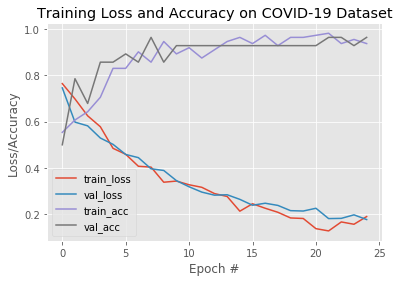

In [24]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [25]:
model_json = model.to_json()
open('architecture.json', 'w').write(model_json)
model.save_weights('weights.h5', overwrite=True)

In [26]:
from sklearn.externals import joblib
joblib.dump(H.history, 'history.pkl') 

/home/sarthak/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['history.pkl']